In [22]:
#Import All Important Libraries
import librosa
from pydub import AudioSegment
import subprocess
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [23]:
#function for extracting mfcc, chroma, and mel features from sound file
def extract_feature(file_name, mfcc, chroma, mel):
    result=np.array([])
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            # X = Xx.copy()
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            # X = Xx.copy()
            # stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        # if chroma:
        if mel:
            # X = Xx.copy()
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [187]:
#Define the motions dictionary
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

#Emotions we want to observe
f = ['angry', 'sad', 'neutral', 'happy', 'excited']
s= ['anxious', 'apologetic', "pensive", 'worried', 'enthusiastic']
observed_emotions = s

In [188]:
#Load the data and extract features for each sound file
def load_data(test_size = 0.2):
    x, y = [], []
    for file in glob.glob('./Datasets/JL Corpus/*.wav'):
        # print(file)
        file_name=os.path.basename(file)
        #converting stereo audio to mono
        sound = AudioSegment.from_wav(file)
        sound = sound.set_channels(1)
        sound.export(file, format="wav")
        emotion=file_name.split(" ")[-2]
        # print('emotion=',emotion)

        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc = True, chroma = True, mel = True)
        x.append(feature)
        y.append(emotion)
    # for file in glob.glob('./Datasets/Emov-DB/*.wav'):
    #     print(file)
    #     file_name=os.path.basename(file)
    #     #converting stereo audio to mono
    #     sound = AudioSegment.from_wav(file)
    #     # sound = sound.set_channels(1)
    #     # sound.export(file, format="wav")
    #     emotion=file_name.split(" ")[-2]
    #     print('emotion=',emotion)

    #     # if emotion not in observed_emotions:
    #     #     continue
    #     feature = extract_feature(file, mfcc = True, chroma = True, mel = True)
    #     x.append(feature)
    #     y.append(emotion)
    return train_test_split(np.array(x), y, test_size = test_size, random_state = 9)

In [196]:
x_train,x_test,y_train,y_test=load_data(test_size=0.4)
# Shape of train and test set and Number of features extracted
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(288, 192)
Features extracted: 180


In [197]:
#Initialise Multi Layer Perceptron Classifier
model = MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (1000,), learning_rate = 'adaptive', max_iter = 500)

In [198]:
history=model.fit(x_train, y_train)

In [199]:
history

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(1000,),
              learning_rate='adaptive', max_iter=500)

In [200]:
#Predict for the test set••••••••••
y_pred = model.predict(x_test)

In [201]:
#Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 97.92%


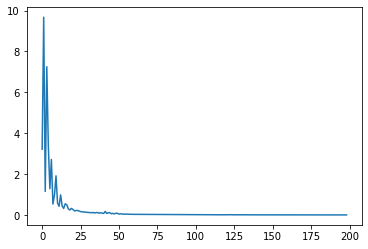

In [202]:
loss_plot=model.loss_curve_
plt.plot(loss_plot)
plt.show()